In [13]:
import scipy.io
import matplotlib.pyplot as plt
from numpy import *
import sys
sys.path.append('../')
from simfuncs import *

In [14]:
import os
sys.path.append(os.path.join('..','mot-sim')) # why?

def process_csv(fname, newline='', cols=True, skiprows=1):
    rows = []
    with open(fname, 'r', newline=newline) as f:
        reader = csv.reader(f, delimiter=',')

        while skiprows > 0:
            reader.__next__()
            skiprows -= 1
        
        for row in reader:
            try:
                rows.append([float(x) for x in row if x != ''])
            except ValueError:
                print(f"row is problematic: \n {row}")

    if cols:
        return array(rows).T
    
    return rows

## Signal Hound
data exported as csv from Spike program

In [4]:
fpath = 'C:\\Users\\prest\\Documents\\SignalHound\\'
files = [fpath+name for name in 
         ['808_laser_1pt5A_1Hz_500kHz.csv',
         '808_laser_3A_1Hz_500kHz.csv',
         '808_laser_pt8A_1Hz_500kHz.csv',
         '808_laser_pt9A_1Hz_500kHz.csv',
         'background_1Hz_500kHz.csv']
        ]

In [5]:
# sample the file contents, get time increment
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
        if i == 1:
            t_incr = float(row[-1])     
        if i < 10:
            print(row)

['952.382620', ' -51.8245']
['2857.144492', ' -55.1114']
['4761.906365', ' -62.2933']
['6666.668237', ' -77.7545']
['8571.430110', ' -88.2259']
['10476.191982', ' -84.5513']
['12380.953854', ' -84.4927']
['14285.715727', ' -85.6648']
['16190.477599', ' -80.7151']
['18095.239471', ' -78.2957']


In [9]:
data = array([process_csv(f, newline='', cols=True, skiprows=0)
             for f in files])
data.shape

(5, 2, 262)

In [7]:
2**array([1,2,3])

array([2, 4, 8], dtype=int32)

Text(0.5, 1.0, 'Aerodiode 808 nm laser - RIN')

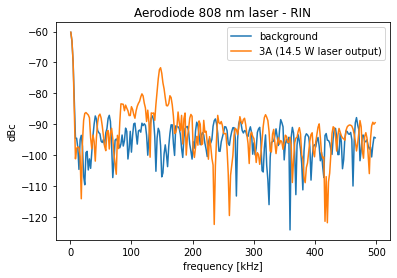

In [12]:
fig,ax = plt.subplots()
# ax.plot(data[-1][0]/1e3,data[-1][1],label='background')
# for i in range(data.shape[0]-1):
#     ax.plot(data[1][0],data[i][1],label=f'{i}')

dBm_to_V = lambda dBm: 10**(array(dBm)/20) 

vdc = 2.68
vbg = dBm_to_V(data[-1][1])
vsgnl = dBm_to_V(data[1][1])
dBm_sgnl = 20*log10(vsgnl/vdc)
dBm_bg = 20*log10(vbg/vdc)

# ax.plot(data[1][0]/1e3,data[1][1]-log10(2.68),label='3A (14.5 W laser output)')
ax.plot(data[-1][0]/1e3,dBm_bg,label='background')
ax.plot(data[1][0]/1e3,dBm_sgnl,label='3A (14.5 W laser output)')

ax.legend()
ax.set_ylabel("dBc")
ax.set_xlabel("frequency [kHz]")
ax.set_title("Aerodiode 808 nm laser - RIN")

## SR785

In [1]:
# for analyzing the .mat files produced by SR785 Viewer program (on Hexagon4, Coffee Lab)
# or ascii files (see Kara's notes on the wiki for converting from d78)
# Preston Huft, Spring 2020

# winter 2020: on the SR785, when you hit Disk, you can rename the file to be myfile.mat, and then you don't need to
# reformat later

### 2021.11.10

In [30]:
## GET DATA FROM ASCII FILES
fpath = 'C:\\Users\\prest\\Documents\\SRSdata\\20211110\\'
ascfiles = [fpath+f+'.asc' for f in
         ['pt6A_30mVdc','1pt5A_488mVdc','3A_155mVdc',
         '4A_32mVdc','5A_40mVdc']]
ascdata = []
for af in ascfiles:
    with open(af, 'r') as f:
        lines = f.readlines()
        data = []
        for i, line in enumerate(lines):
            if i > 14:
                data.append([float(l) for l in line.split(' ') if is_numeric(l)])
    ascdata.append(array(data))
ascdata = array(ascdata)

In [31]:
ascdata.shape

(5, 800, 2)

In [36]:
hzdata = []
vdata = []
for i in range(ascdata.shape[0]):
    hzdata.append(ascdata[i,:,0])
    vdata.append(ascdata[i,:,1])

Text(0.5, 0, 'frequency [Hz]')

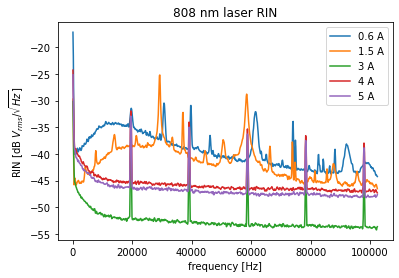

In [51]:
vdc_list = [.030,.488,.155,.032,.040]
labels = ['0.6 A', '1.5 A', '3 A', '4 A', '5 A']
for i in range(ascdata.shape[0]):
    plt.plot(hzdata[i],0.5*vdata[i] - 10*log10(vdc_list[i]),label=labels[i])
plt.legend()
fig.dpi=200
plt.title('808 nm laser RIN')
plt.ylabel('RIN [dB $V_{rms}/\sqrt{Hz}$]')
plt.xlabel('frequency [Hz]')

In [8]:
# frequency [Hz], voltage [V] (if you selected linear/linear when saving the .mat file)
# hz1,v1 = mat960['srs960rin'].transpose()
hz2,v2 = mat780['srs780arin'].transpose()
hz3,v3 = mat780b['srs780brin'].transpose()
hz4,v4 = ascdata[0].transpose()

# the DC voltage recorded
vdc1 = .80
vdc2 = .67
vdc3 = vdc1
vdc4 = .310

### 2020.10.09

In [5]:
# put your files here
mat960 = scipy.io.loadmat('20200109_960powerspectrum.MAT')
mat780 = scipy.io.loadmat('20200109_780powerspectrum.MAT') # check the pzt file too
mat780b = scipy.io.loadmat('20200109_780Bpowerspectrum.MAT')
# mat780a = scipy.io.loadmat('780_filtercav_noise_eaten_20201223.MAT')

In [6]:
## GET DATA FROM MAT FILES
matfiles = ['20200109_960powerspectrum.MAT','20200109_780powerspectrum.MAT','20200109_780Bpowerspectrum.MAT']
matdicts = [scipy.io.loadmat(f) for f in matfiles] 
# get the keys. these are the filenames entered in the sr785 before hitting Display to Disk
[d.keys() for d in matdicts]

[dict_keys(['srs960rin']),
 dict_keys(['srs780arin']),
 dict_keys(['srs780brin'])]

In [7]:
## GET DATA FROM ASCII FILES
ascfiles = ['srs_filtercav_noise_eaten_rin_20201223.asc']
ascdata = []
for af in ascfiles:
    with open(af, 'r') as f:
        lines = f.readlines()
        data = []
        for i, line in enumerate(lines):
            if i > 14:
                data.append([float(l) for l in line.split(' ') if is_numeric(l)])
    ascdata.append(array(data))

In [24]:
ascdata[0]

array([[ 2.560000e+02, -2.728812e+01],
       [ 5.120000e+02, -3.590691e+01],
       [ 7.680000e+02, -4.229071e+01],
       [ 1.024000e+03, -4.490160e+01],
       [ 1.280000e+03, -4.853709e+01],
       [ 1.536000e+03, -5.100641e+01],
       [ 1.792000e+03, -5.210571e+01],
       [ 2.048000e+03, -5.526241e+01],
       [ 2.304000e+03, -6.045084e+01],
       [ 2.560000e+03, -6.332691e+01],
       [ 2.816000e+03, -6.446348e+01],
       [ 3.072000e+03, -6.629295e+01],
       [ 3.328000e+03, -6.815503e+01],
       [ 3.584000e+03, -6.733893e+01],
       [ 3.840000e+03, -6.290952e+01],
       [ 4.096000e+03, -6.048627e+01],
       [ 4.352000e+03, -6.175719e+01],
       [ 4.608000e+03, -6.170640e+01],
       [ 4.864000e+03, -6.061728e+01],
       [ 5.120000e+03, -6.317055e+01],
       [ 5.376000e+03, -6.718557e+01],
       [ 5.632000e+03, -6.856498e+01],
       [ 5.888000e+03, -6.893962e+01],
       [ 6.144000e+03, -7.016185e+01],
       [ 6.400000e+03, -7.141998e+01],
       [ 6.656000e+03, -7

In [8]:
# frequency [Hz], voltage [V] (if you selected linear/linear when saving the .mat file)
# hz1,v1 = mat960['srs960rin'].transpose()
hz2,v2 = mat780['srs780arin'].transpose()
hz3,v3 = mat780b['srs780brin'].transpose()
hz4,v4 = ascdata[0].transpose()

# the DC voltage recorded
vdc1 = .80
vdc2 = .67
vdc3 = vdc1
vdc4 = .310

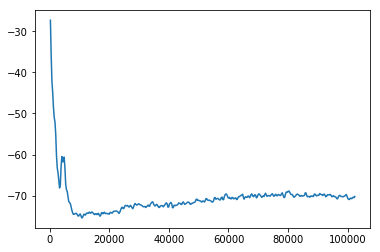

In [9]:
plt.plot(hz4, v4)

C:\Users\gothr\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


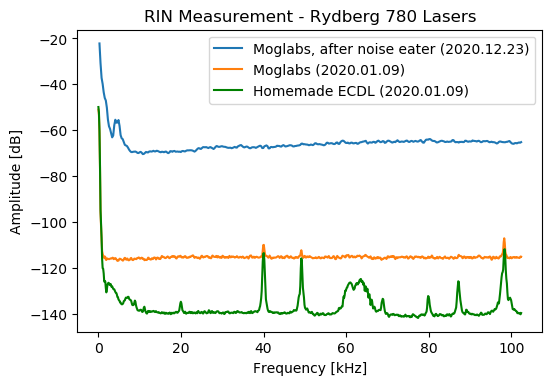

In [10]:
fig, ax = plt.subplots(dpi=100)
ax.plot(hz4/1e3,10*log10((10**(v4/10)/vdc4)), label='Moglabs, after noise eater (2020.12.23)') # note the base 10 log and 
ax.plot(hz3/1e3,10*log10(v3/vdc3), label='Moglabs (2020.01.09)',) # note the base 10 log and 
ax.plot(hz2/1e3,10*log10(v2/vdc2), label='Homemade ECDL (2020.01.09)',c='green')
# ax.plot(hz1/1e3,10*log10(v1/vdc1), label='960 (Toptica ECDL)',c='red')
ax.set_title("RIN Measurement - Rydberg 780 Lasers")
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Amplitude [dB]")
ax.legend()
fname = 'rin_compare_780A_20201223.png'
# plt.savefig(fname, bbox_inches='tight')

In [32]:
fname = 'soln_rin_780_20201223.csv'
lbls = ['frequency [Hz]',
        'Moglabs after noise eater']

rin1 = [vdc4] + list(v4)
data = [ hz4, rin1 ] # first datum in each rin column is the dc voltage
# soln_to_csv(fname, data, lbls)

wrote data to soln_rin_780_20201223.csv


In [22]:
fname = 'soln_rin_compare_780_20200109.csv'
lbls = ['frequency [Hz]',
        'Moglabs (2020.01.09)',
        'Homemade ECDL (2020.01.09)']
data3 = [vdc3]
data3 += list(v3)
data2 = [vdc2]
data2 += list(v2)
data = [ hz2, data3, data2 ] # first datum in each column is the dc voltage
# soln_to_csv(fname, data, lbls)

wrote data to soln_rin_compare_780_20200109.csv


In [33]:
(f,x1), testlbls = soln_from_csv(fname)

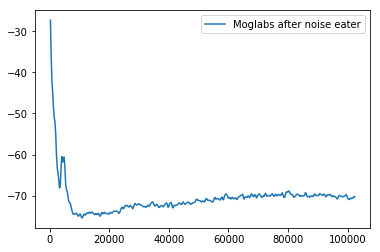

In [35]:
plt.plot(f,x1[1:], label=testlbls[1])
# plt.plot(f,10*log10(x1[1:]/x1[0]), label=testlbls[1])
plt.legend()

In [ ]:
# the DC voltage recorded
vdc1 = .80
vdc2 = .67
vdc3 = .3

fig, ax = plt.subplots()
ax.plot(hz3/1e3,10*log10(v3/vdc3), label='780B (Moglabs ECDL)',) # note the base 10 log and 
# ax.plot(hz2/1e3,10*log10(v2/vdc2), label='780A (Homemade ECDL)',c='green')
# ax.plot(hz1/1e3,10*log10(v1/vdc1), label='960 (Toptica ECDL)',c='red')
ax.set_title("RIN Measurement 2020/01/09")
ax.set_xlabel("Frequency [kHz]")
ax.set_ylabel("Amplitude [dB]")
ax.legend()